In [1]:
import sys
COMP_NAME = "icecube-neutrinos-in-deep-ice"
sys.path.append(f"/home/anjum/kaggle/{COMP_NAME}/")

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.config import INPUT_PATH, OUTPUT_PATH

# Confirm sensor distances

In [2]:
sensors = pd.read_csv(INPUT_PATH / "sensor_geometry.csv")
sensors.describe()

,sensor_id,x,y,z
count,5160.000000,5160.000000,5160.000000,5160.000000
mean,2579.500000,5.870829,-2.518609,-23.905766
std,1489.708025,285.151213,269.409729,296.456563
min,0.000000,-570.900000,-521.080000,-512.820000
25%,1289.750000,-224.090000,-209.070000,-283.200000
50%,2579.500000,16.990000,-6.055000,-35.115000
75%,3869.250000,224.580000,211.660000,228.557500
max,5159.000000,576.370000,509.500000,524.560000


In [3]:
for i in range(len(sensors) // 60):
    start, end = i * 60, (i * 60) + 60
    string = sensors.iloc[start:end]
    length = string["z"].max() - string["z"].min()
    
    if i + 1 == 63:
        print(i + 1, (start, end), length, length / 60, string["z"].min(), string["z"].max())
    
    if i == 77:
        break

63 (3720, 3780) 1004.22 16.737000000000002 -506.4 497.82


- String 63 spacing = 16.737m
- Top = -506.4m
- Base = 497.82m
- Length = 1004.22m

# Estimate datum and convert depth to z

In [4]:
# Data from https://arxiv.org/pdf/1301.5361.pdf in string 63
df = pd.read_csv(INPUT_PATH / "ice_transparency.txt", delim_whitespace=True)
df

,depth,scattering_len,absorption_len
0,1398.4,13.2,45.1
1,1408.4,14.0,48.6
2,1418.4,14.7,53.2
3,1428.4,17.0,57.6
4,1438.4,16.0,57.6
...,...,...,...
105,2448.2,77.6,232.1
106,2458.2,79.8,259.4
107,2468.3,89.4,276.1
108,2478.4,80.7,244.3


In [5]:
icecube_top = 1450
icecube_base = 16.737 * 60 + 1450
icecube_length = icecube_base - icecube_top
datum = icecube_top + (icecube_length / 2)
print(datum)  # This is within 2m of the published figure

datum = 1950  # See footnote 8 of page 29 in https://arxiv.org/pdf/1301.5361.pdf

1952.11


In [6]:
df["z"] = df["depth"] - datum
df

,depth,scattering_len,absorption_len,z
0,1398.4,13.2,45.1,-551.6
1,1408.4,14.0,48.6,-541.6
2,1418.4,14.7,53.2,-531.6
3,1428.4,17.0,57.6,-521.6
4,1438.4,16.0,57.6,-511.6
...,...,...,...,...
105,2448.2,77.6,232.1,498.2
106,2458.2,79.8,259.4,508.2
107,2468.3,89.4,276.1,518.3
108,2478.4,80.7,244.3,528.4


# Apply to event data

In [7]:
from sklearn.preprocessing import RobustScaler

In [8]:
df["z_norm"] = df["z"] / 500
df[["scattering_len_norm", "absorption_len_norm"]] = RobustScaler().fit_transform(df[["scattering_len", "absorption_len"]])
df

,depth,scattering_len,absorption_len,z,z_norm,scattering_len_norm,absorption_len_norm
0,1398.4,13.2,45.1,-551.6,-1.1032,-0.706532,-0.746711
1,1408.4,14.0,48.6,-541.6,-1.0832,-0.677093,-0.707529
2,1418.4,14.7,53.2,-531.6,-1.0632,-0.651334,-0.656031
3,1428.4,17.0,57.6,-521.6,-1.0432,-0.566697,-0.606773
4,1438.4,16.0,57.6,-511.6,-1.0232,-0.603496,-0.606773
...,...,...,...,...,...,...,...
105,2448.2,77.6,232.1,498.2,0.9964,1.663293,1.346767
106,2458.2,79.8,259.4,508.2,1.0164,1.744250,1.652393
107,2468.3,89.4,276.1,518.3,1.0366,2.097516,1.839351
108,2478.4,80.7,244.3,528.4,1.0568,1.777369,1.483347


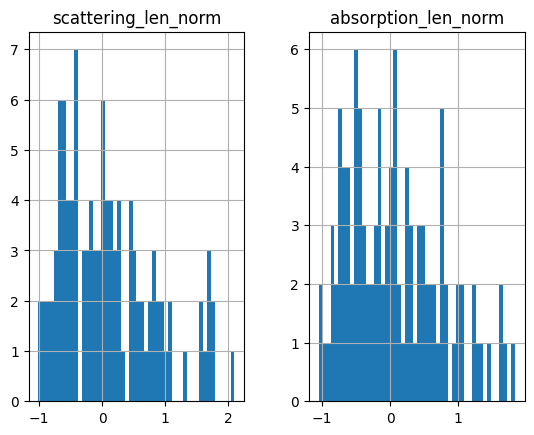

In [9]:
df[["scattering_len_norm", "absorption_len_norm"]].hist(bins=50);

In [10]:
from scipy.interpolate import interp1d

In [11]:
f_scattering = interp1d(df["z_norm"], df["scattering_len"])
f_absorption = interp1d(df["z_norm"], df["absorption_len"])

# f_scattering = interp1d(df["z_norm"], df["scattering_len_norm"])
# f_absorption = interp1d(df["z_norm"], df["absorption_len_norm"])

In [12]:
data = torch.load(INPUT_PATH / "train_events" / "batch_1" / "event_24.pt")
data

Data(x=[61, 7], y=[2], n_pulses=61)

In [13]:
z = data.x[:, 2].numpy()
z

array([ 0.41316,  0.42546, -0.3492 , -0.3492 ,  0.362  ,  0.71576,
        0.32722, -0.35634,  0.90158,  0.69602,  0.69602, -0.41094,
       -0.41094, -0.41094, -0.27144, -0.43898,  0.4678 ,  0.4678 ,
       -0.39558,  0.3413 ,  0.42426, -0.7018 , -0.7018 ,  0.08972,
        0.20436,  0.31944, -0.36236,  0.38268,  0.38268,  0.41672,
        0.41672,  0.41672,  0.41672,  0.15192, -0.69796, -0.69796,
        0.55288,  0.59176,  0.5577 , -0.4129 ,  0.48962,  0.3146 ,
        0.51884, -0.2208 , -0.61016,  0.62852, -0.3244 ,  0.99902,
        0.55712,  0.38434,  0.29046, -0.87616,  0.05168, -0.62866,
       -0.66334, -0.7981 , -0.09224, -0.64194,  0.08556,  0.08556,
       -0.49768], dtype=float32)

In [14]:
scattering_values = f_scattering(z)
absorption_values = f_absorption(z)

scattering_values

array([47.49878918, 40.36379279, 35.36299861, 35.36299861, 38.1879921 ,
       75.30360011, 41.72525864, 34.3991012 , 57.07168246, 75.59969989,
       75.59969989, 20.22060009, 20.22060009, 20.22060009, 42.82727288,
       20.65930046, 29.153534  , 29.153534  , 21.85820132, 33.74750059,
       41.1678064 , 21.74400135, 21.74400135, 10.1752002 ,  5.80959927,
       48.40504431, 33.58639992, 49.81119973, 49.81119973, 46.21959806,
       46.21959806, 46.21959806, 46.21959806,  7.84139884, 22.20479771,
       22.20479771, 46.5743956 , 54.43699848, 48.34108343, 20.20099999,
       29.44239999, 50.95600174, 35.68560358, 30.2279996 , 34.08788155,
       59.82646657, 35.45600031, 77.88819785, 48.18891749, 50.20959718,
       43.44358423, 35.00912272, 16.44580009, 25.75868712, 20.0679945 ,
       13.99500059, 41.5204005 , 18.38830129,  9.92560009,  9.92560009,
       29.50940172])

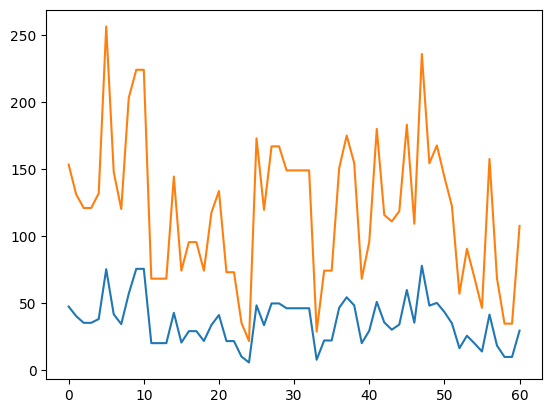

In [15]:
plt.plot(scattering_values)
plt.plot(absorption_values);

In [16]:
scattering_values = torch.tensor(scattering_values, dtype=torch.float32).view(-1, 1)

In [18]:
torch.cat([data.x, scattering_values], dim=1).shape

torch.Size([61, 8])